In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from collections import Counter
from collections import defaultdict
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import torch.nn as nn
import time
import os
import torch
import copy
import torch.nn.functional as F
import wandb
import json
import heapq
import pandas as pd
import pickle



# Seeds for reproducibility
def set_seeds(seed: int = 123):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
""" PLOT SETTINGS """

plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "font.size": 18,            # base font size
    "axes.titlesize": 24,       # axis titles
    "axes.labelsize": 22,       # axis labels
    "xtick.labelsize": 18,      # X axis numbers
    "ytick.labelsize": 18,      # Y axis numbers
    "legend.fontsize": 18,      # legend text
    "lines.linewidth": 3.0      # line thickness
})


In [ ]:
# --- Define DINOWithHead ---
class DINOWithHead(nn.Module):
    def __init__(self, backbone, num_classes=100, p=None):
        super().__init__()
        self.backbone = backbone
        layers = []
        if p is not None:
            layers.append(nn.Dropout(p=p))
        layers.append(nn.Linear(384, num_classes))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)
        out = self.head(features)
        return out

## Data import and loader creation

In [ ]:
""" DATASET DOWNLOAD """
ROOT = './data'
BATCH_SIZE=64
#BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())





""" SPLIT TOT_TRAININ in VALIDATION and TRAIN """

def split_dataset(tot_train_data, valid_ratio=0.8):
    """
    Splits the given dataset randomly into training and validation subsets
    """
    train_size = int(valid_ratio * len(tot_train_data))
    val_size = len(tot_train_data) - train_size
    train_data, val_data = random_split(tot_train_data, [train_size, val_size])
    return train_data, val_data

train_data, val_data = split_dataset(tot_train_data, valid_ratio=0.8)



""" DATA TRANSFORMATION """

def data_trasform(dataset, data_augmentation=False):   ### train_data or tot_train_data
    """
    Returns train and val/test transforms based on dataset stats.
    Dataset (for computing mean and std) can be either training only or combined train+validation.

    If data_augmentation=True, applies augmentation on training transforms, otherwise only resize and normalize.
    """

    # MEAN and VARIANCE (considering 3 channels)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten H*W
        mean += img.mean(1)
        std += img.std(1)
        nb_samples += 1

    mean /= nb_samples
    std /= nb_samples


    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomCrop(64, padding=4),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    ### NO DATA AUGMENTATION!
    val_test_transforms = transforms.Compose([
        transforms.Resize(64),                    # Resize
        transforms.ToTensor(),                     # Convert to tensor
        transforms.Normalize(mean=mean, std=std)   # Normalization using the training statistics
    ])


    return train_transforms, val_test_transforms






""" DATA TRANSFORMATION and LOADERS """

### ===== For hyperparameter tuning considering train_data and val_data =====
train_transforms, val_test_transforms = data_trasform(train_data)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



### ===== For model testing considering tot_train_data and test_data =====
train_transforms, val_test_transforms = data_trasform(tot_train_data)

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=False, transform=train_transforms)
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=False, transform=val_test_transforms)

tot_train_loader = DataLoader(tot_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Functions Client

In [ ]:
""" SPLIT INTO K CLIENTS: iid and non-iid distributions  """

def iid_shard(dataset, K):
    """
    Splits the dataset into K disjoint subsets (one per client) in an IID fashion. Each client receives ~len(dataset)/K samples,
    drawn uniformly at random across all classes.
    """
    num_items_per_client = len(dataset) // K
    remainder = len(dataset) % K
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    client_data = {}  # Creation of a dictionary for clients
    start = 0
    for i in range(K):
        # give +1 to the first `remainder` clients
        add = num_items_per_client + (1 if i < remainder else 0)
        end = start + add
        client_data[i+1] = Subset(dataset, all_indices[start:end])
        start = end

    return client_data


def noniid_shard(dataset, K, Nc):
    """
    Splits the dataset into K disjoint subsets (one per client) in a non-IID fashion.
    Disjoint dataset: each sample must belong to exactly one client and cannot be duplicated.
    Nc: each client receives samples from Nc distinct classes, to simulate variability of data across clients.
    """
    # === Feasibility check ===
    all_classes = set(label for _, label in dataset)
    num_classes = len(all_classes)
    if Nc > num_classes:
        raise ValueError(f"Cannot assign {Nc} classes per client: only {num_classes} classes available.")


    # === Step 1: Organize data by class ===
    # This ensures we can select samples from specific classes without duplication.
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)    # key: class, value: list of idxs of the corresponding class

    # === Step 2: Shuffle samples within each class ===
    # Prevents consecutive samples from going to the same clients repeatedly.
    for cls in label_to_indices:
        random.shuffle(label_to_indices[cls])

    # === Step 3: Prepare the list of clients and shuffle it ===
    # Guarantees random assignment of classes to clients.
    all_classes = list(label_to_indices.keys())

    client_class_map = {}
    for client_id in range(1, K+1):        # Pre-select Nc classes per client at the beginning.
        client_class_map[client_id] = random.sample(all_classes, Nc)

    client_data = {cid: [] for cid in range(1, K+1)}    # Initialize empty client datasets
    class_to_clients = defaultdict(list)     # For each class, keep track of clients that have it (reverse map from class → clients that have that class)
    for cid, classes in client_class_map.items():
        for cls in classes:
            class_to_clients[cls].append(cid)


    # === Step 4: Distribute samples in rounds ===
    # Distributing samples to clients in rounds
    for cls, indices in label_to_indices.items():    # Iterate over all classes, where indices is the list of the samples for the considered class
        clients = class_to_clients[cls]  # clients that want this class
        if not clients:
            continue
        i = 0
        while indices:
            client_id = clients[i % len(clients)]  # cycling continuously through the list of clients
            sample = indices.pop()                 # take one sample and it removes it so it will not be repeated
            client_data[client_id].append(sample)  # assign to this client
            i += 1

     # === Step 5: Convert sample index lists into Subsets ===
    for cid in client_data:
        client_data[cid] = Subset(dataset, client_data[cid])

    return client_data

## Class Client

In [ ]:
def compress_mask(mask_dict):
    """
    Convert each 0/1 tensor in the mask into a compressed bit array.
    Returns a dictionary: {param_name: (packed_uint8_array, original_shape)}
    """
    compressed = {}
    for name, tensor in mask_dict.items():
        # Move tensor to CPU, cast to uint8, flatten, and convert to numpy
        arr = tensor.detach().to('cpu').to(torch.uint8).contiguous().view(-1).numpy()
        # Pack bits into a compact representation (8x smaller than uint8)
        packed = np.packbits(arr)
        compressed[name] = (packed, tuple(tensor.shape))  # store packed data + original shape
    return compressed


def decompress_mask(compressed_dict):
    """
    Reconstruct torch.uint8 tensors with the original shape (0/1 values).
    """
    mask = {}
    for name, (packed, shape) in compressed_dict.items():
        total = int(np.prod(shape))  # number of elements in original tensor
        # Unpack bits back to 0/1 and trim extra padding
        unpacked = np.unpackbits(packed)[:total]
        # Reshape to original tensor shape and convert to torch.uint8
        mask[name] = torch.from_numpy(unpacked.reshape(shape)).to(torch.uint8)
    return mask



""" CLASS CLIENT"""
class Client:
    def __init__(self, client_id, dataset, loader,
                 mask=None, extra_mask=None, fisher_scores=None,
                 local_weights=None, compressed_mask=None):
        self.client_id = client_id
        self.dataset = dataset
        self.loader = loader

        # Full mask in RAM (0/1 tensors) – only needed during training
        self.mask = mask

        # Lightweight storage version (bit-packed mask)
        self.compressed_mask = compressed_mask

        # Optional: additional mask (depends on your logic)
        self.extra_mask = extra_mask

        # Fisher scores are only needed during calibration;
        # after that, you can set them to None to save memory
        self.fisher_scores = fisher_scores

        # Local weights are not really used in your training loop;
        # kept here only for compatibility
        self.local_weights = local_weights

    def compress_mask(self):
        """
        Compress self.mask into self.compressed_mask and free RAM
        """
        if self.mask is not None:
            # Make sure mask tensors are uint8 (0/1 values)
            self.mask = {k: v.to(torch.uint8) for k, v in self.mask.items()}
            self.compressed_mask = compress_mask(self.mask)
            self.mask = None  # release memory

    def decompress_mask(self):
        """
        Rebuild self.mask (0/1 tensors) from self.compressed_mask
        """
        if self.compressed_mask is not None and self.mask is None:
            self.mask = decompress_mask(self.compressed_mask)



    def num_samples(self):
        """
        Returns the number of samples in the client’s local dataset.
        """
        return len(self.dataset)

    @staticmethod
    def print_samples(clients):
        """
        Prints the number of samples each client holds.
        """
        print("Number of samples per client:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    @staticmethod
    def plot_class_distribution(clients, dataset):
        """
        Plots the distribution of classes for a list of clients.
        """
        class_distributions = []

        if hasattr(dataset, 'targets'):
            get_label = lambda idx: dataset.targets[idx]
        elif hasattr(dataset, 'labels'):
            get_label = lambda idx: dataset.labels[idx]
        else:
            get_label = lambda idx: dataset[idx][1]

        for client in clients:
            indices = client.loader.dataset.indices if isinstance(client.loader.dataset, Subset) else list(range(len(client.loader.dataset)))
            labels = [get_label(i) for i in indices]
            class_counts = Counter(labels)
            class_distributions.append(class_counts)

        fig, axes = plt.subplots(nrows=1, ncols=len(clients), figsize=(5 * len(clients), 4))
        if len(clients) == 1:
            axes = [axes]

        for i, (client, class_counts) in enumerate(zip(clients, class_distributions)):
            axes[i].bar(class_counts.keys(), class_counts.values(), color='orange')
            axes[i].set_title(f'Client {client.client_id}')
            axes[i].set_xlabel('Classes')
            axes[i].set_ylabel('Frequency')
            axes[i].set_xticks(list(class_counts.keys()))

        plt.tight_layout()
        plt.show()



""" CLIENT CREATION """
def create_clients(data, K, Nc=None, flag = "iid"):   ### data is either train_data or tot_data
    """
    Splits the dataset into K subsets, either IID or non-IID, and returns both the client datasets and their corresponding DataLoaders
    """
    if flag == "iid":     # We want iid
      client_datasets = iid_shard(data, K)     # Split the training data into K clients

    else:    # We want non iid
      client_datasets = noniid_shard(data, K, Nc)

    client_loaders = {}    ### Creation of a DataLoader for each client

    for client_id, subset in client_datasets.items():
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
        client_loaders[client_id] = loader       # The clients id are the indices+1
    return client_datasets, client_loaders


def create_client_objects(data, K, Nc=None, flag="iid", batch_size=64, verbose=True):
    """
    Creates and returns a list of Client objects, each containing its own dataset and DataLoader, ready for use in federated learning
    """

    # === CHECK ===
    if flag == "non-iid" and Nc is None:
        raise ValueError("Nc must be set when flag='non-iid'")

    client_datasets, client_loaders = create_clients(data, K, Nc, flag=flag)
    clients = []
    for client_id in client_datasets.keys():
        clients.append(Client(client_id, client_datasets[client_id], client_loaders[client_id]))


    if verbose:
        print("Clients and their sample sizes:")
        for client in clients:
            print(f"Client {client.client_id}: {client.num_samples()} samples")

    return clients


## Server model evaluation

In [ ]:
""" MODEL EVALUATION """
def evaluate_model(model, data_loader, criterion):
    """
    The evaluate_model function computes the average loss and accuracy of a model on a dataset without updating its weights.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(data_loader.dataset)
    avg_acc = total_corrects.double() / len(data_loader.dataset)

    return avg_loss, avg_acc.item()



In [ ]:
""" CHECKPOINT FUNCTION """
def save_checkpoint(model, epoch, train_losses, train_accuracies,
                    val_test_losses, val_test_accuracies, best_acc, best_loss, best_model_wts, path):
    """
    The save_checkpoint function saves the model’s state, training/validation metrics,
    and best performance to a specified file path.
    """
    dir_name = os.path.dirname(path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_test_losses': val_test_losses,
        'val_test_accuracies': val_test_accuracies,
        'best_acc': best_acc,
        'best_loss': best_loss,
        'best_model_state_dict': best_model_wts
    }
    torch.save(checkpoint, path)



def init_checkpoint(model, path=None, device='cpu', verbose = True):
    """
    Initialize a checkpoint. If path is None, create default checkpoint with empty/default values.
    If path is given and file exists, load it.
    Returns: start_epoch, best_acc, best_loss, train_losses, train_accuracies, val_test_losses, val_test_accuracies, checkpoint_path, best_model_wts
    """
    if path is None:
        # default path
        os.makedirs("checkpoints", exist_ok=True)
        path = "checkpoints/latest.pth"
        if verbose:
            print(f"Initializing new checkpoint at {path}")
        # save default empty checkpoint
        checkpoint = {
            'epoch': 1,
            'best_acc': 0.0,
            'best_loss': 1e10,
            'train_losses': [],
            'train_accuracies': [],
            'val_test_losses': [],
            'val_test_accuracies': [],
            'model_state_dict': model.state_dict(),
            'best_model_state_dict': copy.deepcopy(model.state_dict())
        }
        torch.save(checkpoint, path)
        return 1, 0.0, 1e10, [], [], [], [], path, copy.deepcopy(model.state_dict())

    else:
        # load existing checkpoint
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Checkpoint file {path} does not exist.")

        print(f"Loading checkpoint from {path}")
        checkpoint = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = checkpoint.get('best_model_state_dict', copy.deepcopy(model.state_dict()))
        return (checkpoint['epoch'],
                checkpoint.get('best_acc', 0.0),
                checkpoint.get('best_loss', 1e10),
                checkpoint.get('train_losses', []),
                checkpoint.get('train_accuracies', []),
                checkpoint.get('val_test_losses', []),
                checkpoint.get('val_test_accuracies', []),
                path,
                best_model_wts )



## Train client

In [ ]:
""" TRAINING FUNCTION """
def train_model_client(model, criterion, optimizer, scheduler, client: Client, J=5, device=None):    ### Single client
    """
    Trains a model locally on a single client for J epochs.
    Performs forward pass, computes loss, backpropagation, and updates weights using the given optimizer.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_loader = client.loader

    # ========== TRAINING ==========
    for j in range(J):   # "inner" loop
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels).item()

        if scheduler is not None:
            scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects / len(train_loader.dataset)

    return epoch_train_loss, epoch_train_acc    # Return the last performances


## Mask & Fine tuning

In [ ]:
""" MASK COMPUTATION & CALIBRATION """

def compute_fisher_scores(client, model, device):
    """
    Compute diagonal Fisher Information scores for a client using client.loader.
    Stores results in client.fisher_scores.
    """
    model.eval()  # set model to evaluation mode

    # Initialize Fisher scores if not already present
    if not hasattr(client, 'fisher_scores') or client.fisher_scores is None:
        client.fisher_scores = {
            name: torch.zeros_like(param, device="cpu")
            for name, param in model.named_parameters() if param.requires_grad
        }

    num_batches = 0  # counter for normalization

    # Iterate over client data
    for inputs, labels in client.loader:
        num_batches += 1
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()  # reset gradients
        outputs = model(inputs)

        # Compute log-probabilities
        log_probs = F.log_softmax(outputs, dim=1)

        # Sample labels from the predicted distribution: y ~ p(y|x)
        sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)

        # Compute NLL loss on sampled labels and backpropagate
        loss = F.nll_loss(log_probs, sampled_y, reduction="mean")
        loss.backward()

        # Accumulate squared gradients for each parameter
        for name, param in model.named_parameters():
            if param.grad is not None:
                client.fisher_scores[name] += param.grad.detach().cpu() ** 2

    # Normalize Fisher scores by number of batches
    for name in client.fisher_scores.keys():
        client.fisher_scores[name] /= num_batches





def calibrate_mask_for_client(client, model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005 , keep="least"):
    # Initial Mask: all 1 (uint8) only for trainable parameters
    mask = {name: torch.ones_like(param, device="cpu", dtype=torch.uint8)
            for name, param in model.named_parameters() if param.requires_grad}
    client.mask = mask  # RAM

    # Evaluate fisher e uploading mask R times
    for r in range(1, R + 1):
        current_density = (1 - final_sparsity) ** (r / R)
        current_sparsity = 1 - current_density
        print(f"[Round = {r}] Sparsity = {current_sparsity:.4f}")

        compute_fisher_scores(client, model, device)
        fisher_scores = client.fisher_scores  # dict {name: tensor float}

        # --- Flatten all scores ---
        all_scores = torch.cat([score.view(-1) for score in fisher_scores.values()])

        # --- Evaluate treshold with topk ---
        num_keep_global = int(len(all_scores) * current_density)
        num_keep_global = max(1, min(num_keep_global, len(all_scores)))

        if keep == "least":
            # take the least important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=False)
        elif keep == "most":
            # take the best important weights
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=True)
        elif keep == "random":
            idx = torch.randperm(len(all_scores))[:num_keep_global]
        else:
            raise ValueError("keep must be 'least', 'most', or 'random'")

        # build global_keep
        global_keep = torch.zeros_like(all_scores, dtype=torch.bool)
        global_keep[idx] = True

        # --- Redistribute the threshold layer by layer ---
        new_mask = {}
        start = 0
        for name, score in fisher_scores.items():
            numel = score.numel()
            keep_tensor = global_keep[start:start+numel].view_as(score)
            new_mask[name] = (keep_tensor.to(torch.uint8) * client.mask[name])
            start += numel

        # upload current mask
        client.mask = new_mask
        total_ones = sum(mask.sum().item() for mask in client.mask.values())
        #print(f"total active parameters: {total_ones}")
        total_params = sum(mask.numel() for mask in client.mask.values())
        perc_active = 100 * total_ones / total_params
        print(f"Parametri attivi: {total_ones}/{total_params} ({perc_active:.2f}%)")

        # mini-training with SparseSGD + current mask
        param_to_name = {id(param): n for n, param in model.named_parameters()}
        optimizer = SparseSGD(model.parameters(), lr=lr, weight_decay=weight_decay, mask_dict=client.mask, param_to_name=param_to_name)
        local_model = copy.deepcopy(model).to(device)
        train_model_client(local_model, criterion=nn.CrossEntropyLoss(), optimizer=optimizer,
                           scheduler=None, client=client, J=1, device=device)

    # End calibrazione: free memory by fisher scores
    client.fisher_scores = None

    # compress mask
    client.compress_mask()



def calibrate_all_clients(clients, global_model, device, R=5, final_sparsity=0.9, lr=0.005, weight_decay=0.00005, keep ="least"):
    """
    Apply mask calibration for all clients.
    """
    for client in clients:
        calibrate_mask_for_client(client, global_model, device, R=R, final_sparsity=final_sparsity, lr=lr, weight_decay=weight_decay, keep=keep)
        print(f"Client {client.client_id} -> mask calibrated (sparsity={final_sparsity})")


## SparseSGD

In [ ]:
import torch
from torch.optim import SGD

class SparseSGD(torch.optim.SGD):
    def __init__(self, params, lr=0.01, momentum=0, weight_decay=0, mask_dict=None, param_to_name=None):
        super().__init__(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        self.mask_dict = mask_dict  # {name: mask_tensor su CPU}
        self.param_to_name = param_to_name or {}

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Before super().step: gradients ubdate following the mask
        if self.mask_dict is not None:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    name = self.param_to_name.get(id(p), None)
                    if name is not None and name in self.mask_dict:
                        mask = self.mask_dict[name].to(p.device)
                        # applying the gradient mask (block update of masked-out weights)
                        p.grad.mul_(mask.to(dtype=p.grad.dtype))     # CORRESPONDS TO: d_p = d_p * mask

        # SGD steps(momentum, weight_decay, ecc.)
        super().step(closure)

        return loss



## Main Training FL

In [ ]:
def train_test_model_FL(global_model, criterion, LR, MOMENTUM, WEIGHT_DECAY, T_MAX, clients, val_test_loader,
                        num_epochs, C, J, checkpoint_path=None, checkpoints=True, verbose=True, use_sparse=False):
    """
    Federated Learning training loop with FedAvg aggregation and optional SparseSGD.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s = [], [], [], []

    # copy of global weights
    fed_model_weights = {k: v.clone().detach() for k, v in global_model.state_dict().items()}

    for epoch in range(num_epochs):
        round_train_losses = []
        round_train_accs = []

        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"\n--- Federated Round {epoch+1}/{num_epochs} ---")

        # Sampling of clients
        num_clients = max(1, int(C * len(clients)))
        selected_clients = np.random.choice(clients, num_clients, replace=False)

        local_weights = []
        local_sizes = []

        for client in selected_clients:

            local_model = copy.deepcopy(global_model)
            local_model.load_state_dict(fed_model_weights)
            local_model.to(device)

            #  Mapping param->name
            param_to_name = {id(param): name for name, param in local_model.named_parameters()}

            if use_sparse:
                client.decompress_mask()
                optimizer = SparseSGD(local_model.parameters(),
                                      lr=LR,
                                      momentum=MOMENTUM,
                                      weight_decay=WEIGHT_DECAY,
                                      mask_dict=client.mask,
                                      param_to_name=param_to_name)
            else:
                optimizer = torch.optim.SGD(local_model.parameters(),
                                            lr=LR,
                                            momentum=MOMENTUM,
                                            weight_decay=WEIGHT_DECAY)


            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX) if T_MAX else None

            # Training local model
            train_loss, train_acc = train_model_client(local_model, criterion, optimizer, scheduler, client, J, device=device)
            round_train_losses.append(train_loss)
            round_train_accs.append(train_acc)

            if verbose:
                print(f"Client {client.client_id} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # Collecting weights of FedAvg
            local_weights.append({k: v.cpu().detach() for k, v in local_model.state_dict().items()})
            local_sizes.append(client.num_samples())

            # Free GP memory
            del local_model, optimizer, scheduler
            torch.cuda.empty_cache()

        # FedAvg aggregation
        total_samples = sum(local_sizes)
        fed_model_weights = {}
        for key in local_weights[0].keys():
            fed_model_weights[key] = sum([local_weights[i][key] * (local_sizes[i]/total_samples)
                                          for i in range(len(local_weights))])

        # Update global model
        global_model.load_state_dict(fed_model_weights)

        # Global evaluation
        avg_train_loss = np.mean(round_train_losses)
        avg_train_acc = np.mean(round_train_accs)
        val_test_loss, val_test_acc = evaluate_model(global_model, val_test_loader, criterion)
        if verbose or epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"Round {epoch+1} -> Avg Train Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.4f}")
            print(f"Round {epoch+1} -> Val Loss: {val_test_loss:.4f}, Val Acc: {val_test_acc:.4f}")

        val_test_loss_s.append(val_test_loss)
        val_test_acc_s.append(val_test_acc)
        avg_train_loss_s.append(avg_train_loss)
        avg_train_acc_s.append(avg_train_acc)

        # Save checkpoint
        if checkpoints and checkpoint_path:
            torch.save(global_model.state_dict(), f"{checkpoint_path}_round{epoch+1}.pth")

    return global_model, val_test_loss_s, val_test_acc_s, avg_train_loss_s, avg_train_acc_s





# _________________________________________________________________________________________________________________________

# (2) Sparse-Fine Tuning

## (2.A) Hyperparemeter selection

In [ ]:
""" VALIDATION MODEL IID (small and fast head-only training) """

set_seeds(123)
checkpoint_path = None


############################
# === PARAMETERS TO SET ===
FLAG = "iid"    # 'niid'
Nc = None       # {1,5,10,50}
J = 4           # {4,8,16}
############################


# === GENERAL PARAMETERS ===
N_EP = 20    # global rounds (out)
K = 100
C = 0.1
LR = 0.003
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
T_MAX = J   # Same as client rounds (in)
VERBOSE = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === MODEL BACKBONE ===
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16.eval()   # Backbone only evaluation
dino_vits16 = dino_vits16.to(device)

# Freeze backbone parameters
for param in dino_vits16.parameters():
    param.requires_grad = False

# === CREATE GLOBAL MODEL (trainable head) ===
global_model = DINOWithHead(dino_vits16, num_classes=100).to(device)
for param in global_model.head.parameters():
    param.requires_grad = True
global_model.head.train()   # Head trianing

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

# === TRAINING ====
start_time = time.time()


# === CREATE CLIENTS ===
clients = create_client_objects(
data=train_data,     # using trian data
K=K,
Nc=Nc,
flag=FLAG,
batch_size=BATCH_SIZE,
verbose=VERBOSE
)


# === CALL FL TRAINING ===
best_global_model_iid, test_losses_iid, test_accuracies_iid, avg_train_losses_iid, avg_train_accuracies_iid = train_test_model_FL(
        global_model=global_model,
        criterion=criterion,
        LR=LR,
        MOMENTUM=MOMENTUM,
        WEIGHT_DECAY=WEIGHT_DECAY,
        T_MAX=T_MAX,
        clients=clients,
        val_test_loader=val_loader,    # using val data
        num_epochs = N_EP,
        C=C,
        J=J,
        checkpoint_path=checkpoint_path,
        checkpoints=True,
        verbose=VERBOSE,
        use_sparse=False    # Using standard SGD
    )
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_head = {
        "flag": FLAG,
        "J": J,
        "Nc": Nc,
        "epochs": N_EP,
        "avg_train_losses": avg_train_losses_iid,
        "avg_train_accuracies": avg_train_accuracies_iid,
        "test_losses": test_losses_iid,
        "test_accuracies": test_accuracies_iid,
        "training_time_sec": training_time
    }


# === SAVING JSON ===
json_filename = f"results_FL_HEAD_{FLAG}_J{J}_Nc{Nc}_VALIDATION.json"
with open(json_filename, 'w') as f:
    json.dump(results_FL_head, f, indent=2)

# === SAVING CLIENTS ===
clients_filename = f"clients_FL_HEAD_{FLAG}_J{J}_Nc{Nc}_VALIDATION.pkl"
with open(clients_filename, 'wb') as f:
    pickle.dump(clients, f)

# === SAVING WEIGHTS ===
model_filename = f"global_model_FL_HEAD_{FLAG}_J{J}_Nc{Nc}_VALIDATION.pth"
torch.save(global_model.state_dict(), model_filename)

In [ ]:
set_seeds(123)
def wandb_train_sparse(config=None, pretrained_weights=None, existing_clients=None , val_loader=None):

    with wandb.init(config=config, reinit=True):
        config = wandb.config

        # === CREATE and LOAD MODEL on CPU ===
        device_cpu = torch.device("cpu")
        dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
        dino_vits16 = dino_vits16.to(device_cpu)   # remains on CPU

        global_model_cpu = DINOWithHead(backbone=dino_vits16, num_classes=100).to(device_cpu)
        global_model_cpu.load_state_dict(torch.load(pretrained_weights, map_location=device_cpu))
        global_model_cpu.to(device_cpu)
        global_model_cpu.train()

        # === FREEZE only HEAD, BACKBONE TRAINABLE ===
        for name, param in global_model_cpu.named_parameters():
            if name.startswith("head"):
                param.requires_grad = False
            else:
                param.requires_grad = True
        global_model_cpu.head.eval()    # Head in eval mode


        # === 2 copies on GPU ===
        device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        imported_model_calib = copy.deepcopy(global_model_cpu).to(device_gpu)
        imported_model_train = copy.deepcopy(global_model_cpu).to(device_gpu)


        # === IMPORTING CLIENTS ===
        with open(existing_clients, 'rb') as f:
            clients = pickle.load(f)

        # === LOSS FUNCTION ===
        criterion = nn.CrossEntropyLoss()

        # === TRAINING and TESTING ===
        start_time = time.time()

        # === CALIBRATION MASK ===
        start_c_time = time.time()
        print(f'Masking, selection method: {config.keep}')
        calibrate_all_clients(clients, imported_model_calib, device, R=config.c_rounds, final_sparsity=config.target_sparsity, lr=config.lr, keep=config.keep)
        end_c_time = time.time()
        calib_time = round(end_c_time - start_c_time, 2)

        # === TRAIN FL ===
        best_global_model, val_losses, val_accs, avg_train_losses, avg_train_accs = train_test_model_FL(
            global_model=imported_model_train,
            criterion=criterion,
            LR=config.lr,
            MOMENTUM=config.momentum,
            WEIGHT_DECAY=config.weight_decay,
            T_MAX=config.t_max,
            clients=clients,
            val_test_loader=val_loader,    # valdiation loader!
            num_epochs=config.epochs,
            C=config.C,
            J=config.J,
            checkpoint_path=None,
            checkpoints=True,
            verbose=config.verbose,
            use_sparse=True     # Using sparse SGD
        )
        end_time = time.time()
        training_time = round(end_time - start_time, 2)


        # === LOG ===
        for epoch in range(config.epochs):
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_losses[epoch],
                "val_loss": val_losses[epoch] if val_losses else None,
                "train_accuracy": avg_train_accs[epoch],
                "val_accuracy": val_accs[epoch] if val_accs else None,
            })

        # === LOG BEST ===
        if val_accs:
            best_idx = val_accs.index(max(val_accs))

            wandb.run.summary["best_val_accuracy"] = val_accs[best_idx]
            wandb.run.summary["best_val_loss"] = val_losses[best_idx]
            wandb.run.summary["best_train_accuracy"] = avg_train_accs[best_idx]
            wandb.run.summary["best_train_loss"] = avg_train_losses[best_idx]
            wandb.run.summary["calibration_time_sec"] = calib_time

        # === LOG FINAL RESULTS ===
        results_FL_sparse = {
            "flag": config.flag,
            "J": config.J,
            "Nc": config.Nc,
            "epochs": config.epochs,
            "c_rounds": config.c_rounds,
            "c_time": calib_time,
            "sparsity": config.target_sparsity,
            "avg_train_losses": avg_train_losses,
            "avg_train_accuracies": avg_train_accs,
            "test_losses": val_losses,
            "test_accuracies": val_accs,
            "training_time_sec": training_time
        }

        # Log final for W&B
        wandb.log(results_FL_sparse)




### Parameter grid - High sparsity

In [ ]:
wandb.login()

sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'distribution': 'log_uniform_values',
            'min': 0.00001,
            'max': 0.01
        },
        'batch_size': {
            'value': 64
        },
        'momentum': {
            'values': [0.8, 0.9]
        },
        'weight_decay': {
            'distribution': 'log_uniform_values',
            'min': 1e-6,
            'max': 1e-4
        },
        'epochs': {
            'value': 7
        },
        'target_sparsity': {
            'values': [0.7, 0.9]
        },
        'c_rounds': {
            'value': 1
        },
        #'max_batches': {
        #    'values': [7]      # We use all the data in the clients
        #},
        'verbose': {
            'value': True
        },
        'keep': {
            'value': 'least'
        },
        'C': {
            'value': 0.1
        },
        'J': {
            'value': 4
        },
        't_max': {
            'value': 4
        },
        'flag': {
            'value': 'iid'
        },
        'Nc': {
            'value': None
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Project_Sparse_Grid_High")


wandb: Currently logged in as: s308810 (s308810-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: gutnac43
Sweep URL: https://wandb.ai/s308810-politecnico-di-torino/Project_Sparse_Grid_High/sweeps/gutnac43


In [ ]:
wandb.agent(
    sweep_id,
    function=lambda: wandb_train_sparse(
        pretrained_weights="global_model_FL_HEAD_iid_J4_NcNone_VALIDATION.pth",
        val_loader=val_loader,
        existing_clients="clients_FL_HEAD_iid_J4_NcNone_VALIDATION.pkl"
    ),
    count=5
)

wandb: Agent Starting Run: rw09hr4j with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 9.246275817077746e-05
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.7
wandb: 	verbose: True
wandb: 	weight_decay: 1.6903114391569334e-05
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 1 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 2 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 3 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 4 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 5 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 6 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 7 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 8 -> mask calibrated (sparsity=0.7)
[Round = 1] Spa

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▄▂█▄▁▃▄
train_loss,▅█▁▄▇▇▅
training_time_sec,▁
val_accuracy,▁▂▃▄▆▇█
val_loss,█▇▆▄▃▂▁


wandb: Agent Starting Run: zwxmawet with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 0.00014203755189535404
wandb: 	momentum: 0.8
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.9
wandb: 	verbose: True
wandb: 	weight_decay: 1.6347165692367807e-05


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 1 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 2 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 3 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 4 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 5 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 6 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 7 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 8 -> mask calibrated (sparsity=0.9)
[Round = 1] Spa

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▂▄▆█▄▇▁
train_loss,▆▄▃▁▅▄█
training_time_sec,▁
val_accuracy,▁▁▁▄▇▅█
val_loss,█▇▆▄▃▂▁


wandb: Agent Starting Run: aq6q0zd3 with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 6.146354145180871e-05
wandb: 	momentum: 0.8
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.9
wandb: 	verbose: True
wandb: 	weight_decay: 2.5584911637021004e-05


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 1 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 2 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 3 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 4 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 5 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 6 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 7 -> mask calibrated (sparsity=0.9)
[Round = 1] Sparsity = 0.9000
Parametri attivi: 2166566/21665664 (10.00%)
✅ Client 8 -> mask calibrated (sparsity=0.9)
[Round = 1] Spa

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▇▅▇█▇█▁
train_loss,▃▄▂▁▂▁█
training_time_sec,▁
val_accuracy,▅▅▅▅▅▁█
val_loss,█▇▆▄▃▂▁


wandb: Agent Starting Run: coixkqv8 with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 4.329374008154837e-05
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.7
wandb: 	verbose: True
wandb: 	weight_decay: 2.3174381261147153e-05


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 1 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 2 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 3 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 4 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 5 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 6 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 7 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 8 -> mask calibrated (sparsity=0.7)
[Round = 1] Spa

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▁█▆▃▃▇▄
train_loss,█▁▃▆▆▂▄
training_time_sec,▁
val_accuracy,▁▂▃▄▅▇█
val_loss,█▇▆▄▃▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 777t61rf with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 7.56441877899905e-05
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.7
wandb: 	verbose: True
wandb: 	weight_decay: 8.832304255630364e-06


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 1 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 2 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 3 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 4 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 5 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 6 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 7 -> mask calibrated (sparsity=0.7)
[Round = 1] Sparsity = 0.7000
Parametri attivi: 6499699/21665664 (30.00%)
✅ Client 8 -> mask calibrated (sparsity=0.7)
[Round = 1] Spa

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,█▆▁▄▁▆▃
train_loss,▂▃█▂▄▁▅
training_time_sec,▁
val_accuracy,▁▂▄▅▅▇█
val_loss,█▇▅▄▃▂▁


### Parameter grid - Low sparsity

In [ ]:
wandb.login()

sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'distribution': 'log_uniform_values',
            'min': 0.000001,
            'max': 0.001
        },
        'batch_size': {
            'value': 64
        },
        'momentum': {
            'values': [0.8, 0.9]
        },
        'weight_decay': {
            'distribution': 'log_uniform_values',
            'min': 1e-6,
            'max': 1e-4
        },
        'epochs': {
            'value': 7
        },
        'target_sparsity': {
            'values': [0.2, 0.3]
        },
        'c_rounds': {
            'value': 1
        },
        #'max_batches': {
        #    'values': [7]      # We use all the data in the clients
        #},
        'verbose': {
            'value': True
        },
        'keep': {
            'value': 'least'
        },
        'C': {
            'value': 0.1
        },
        'J': {
            'value': 4
        },
        't_max': {
            'value': 4
        },
        'flag': {
            'value': 'iid'
        },
        'Nc': {
            'value': None
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="Project_Sparse_Grid_Low")


wandb: Currently logged in as: s308810 (s308810-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: dbe1d7du
Sweep URL: https://wandb.ai/s308810-politecnico-di-torino/Project_Sparse_Grid_Low/sweeps/dbe1d7du


In [ ]:
wandb.agent(
    sweep_id,
    function=lambda: wandb_train_sparse(
        pretrained_weights="global_model_FL_HEAD_iid_J4_NcNone_VALIDATION.pth",
        val_loader=val_loader,
        existing_clients="clients_FL_HEAD_iid_J4_NcNone_VALIDATION.pkl"
    ),
    count=5
)

wandb: Agent Starting Run: oiwom5jp with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 3.5203920216832125e-06
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.2
wandb: 	verbose: True
wandb: 	weight_decay: 5.122782431990243e-05
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 1 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 2 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 3 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 4 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 5 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 6 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 7 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 8 -> mask calibrated (sparsity=0.2)
[Round 

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▄▃█▃▁▂▂
train_loss,▅█▁▄▇▇▅
training_time_sec,▁
val_accuracy,▁▂▄▅▆▇█
val_loss,█▇▅▄▃▂▁


wandb: Agent Starting Run: 5cryr8hb with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 0.0002864014196658923
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.2
wandb: 	verbose: True
wandb: 	weight_decay: 1.478795062780551e-06


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 1 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 2 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 3 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 4 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 5 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 6 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 7 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 8 -> mask calibrated (sparsity=0.2)
[Round 

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,█▁███▁▁
train_loss,█▆▃▃▂▁▁
training_time_sec,▁
val_accuracy,▁▃▅▆▇▇█
val_loss,█▆▄▃▂▂▁


wandb: Agent Starting Run: 15oek3sd with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 2.156140085000366e-06
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.3
wandb: 	verbose: True
wandb: 	weight_decay: 2.9686912460393077e-06


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 1 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 2 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 3 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 4 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 5 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 6 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 7 -> mask calibrated (sparsity=0.3)
[Round = 1] Sparsity = 0.3000
Parametri attivi: 15165964/21665664 (70.00%)
✅ Client 8 -> mask calibrated (sparsity=0.3)
[Round 

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▆▅▇█▇█▁
train_loss,▃▄▃▁▂▁█
training_time_sec,▁
val_accuracy,▁▂▃▄▆▆█
val_loss,█▇▅▄▃▂▁


wandb: Agent Starting Run: vpq40gv9 with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 0.00018786788647604284
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.2
wandb: 	verbose: True
wandb: 	weight_decay: 1.6444921489272237e-06


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 1 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 2 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 3 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 4 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 5 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 6 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 7 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 8 -> mask calibrated (sparsity=0.2)
[Round 

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,▁▇▃█▂▆▅
train_loss,█▄▅▄▄▁▂
training_time_sec,▁
val_accuracy,▁▄▅▆▇▇█
val_loss,█▆▅▄▂▂▁


wandb: Agent Starting Run: n4mm1vgb with config:
wandb: 	C: 0.1
wandb: 	J: 4
wandb: 	Nc: None
wandb: 	batch_size: 64
wandb: 	c_rounds: 1
wandb: 	epochs: 7
wandb: 	flag: iid
wandb: 	keep: least
wandb: 	lr: 0.0008578074887523372
wandb: 	momentum: 0.9
wandb: 	t_max: 4
wandb: 	target_sparsity: 0.2
wandb: 	verbose: True
wandb: 	weight_decay: 1.0978497706028526e-06


Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


Masking, selection method: least
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 1 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 2 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 3 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 4 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 5 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 6 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 7 -> mask calibrated (sparsity=0.2)
[Round = 1] Sparsity = 0.2000
Parametri attivi: 17332531/21665664 (80.00%)
✅ Client 8 -> mask calibrated (sparsity=0.2)
[Round 

J,▁
c_rounds,▁
c_time,▁
epoch,▁▂▃▅▆▇█
epochs,▁
sparsity,▁
train_accuracy,██▅█▁██
train_loss,▆▄█▄█▇▁
training_time_sec,▁
val_accuracy,▁▂▅▆▆██
val_loss,█▆▄▃▂▂▁


## (2.B) Fine-tuning

In [ ]:
set_seeds(123)
checkpoint_path = None


###########################
# === PARAMETERS TO SET ===
FLAG = "iid"    # 'niid'
Nc = None       # {1,5,10,50}
J = 4           # {4,8,16}
SPARSITY = 0.5
C_ROUNDS = 2     # calibration rounds
############################


# === GENERAL PARAMETERS ===
N_EP = 50
#K = 100
C = 0.1
LR = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
T_MAX = J
VERBOSE = True
KEEP = 'least'

Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


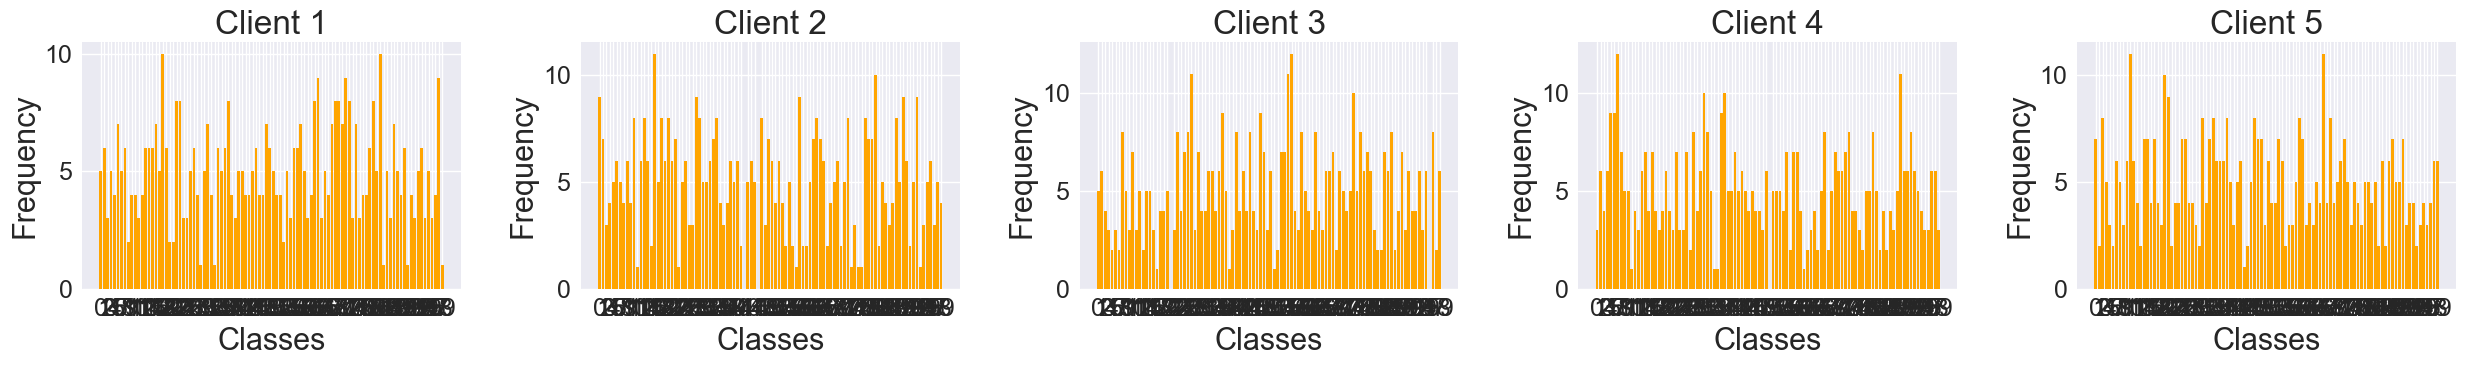

In [ ]:
""" IMPORTING THE MODEL with PRE-TRAINED CLASSIFIER from OUTSIDE """

# === CREATE and LOAD MODEL on CPU ===
device_cpu = torch.device("cpu")
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16 = dino_vits16.to(device_cpu)   # remains on CPU

global_model_cpu = DINOWithHead(backbone=dino_vits16, num_classes=100).to(device_cpu)
model_filename = f"global_model_FL_HEAD_{FLAG}_J{J}_Nc{Nc}.pth"
global_model_cpu.load_state_dict(torch.load(model_filename, map_location=device_cpu))
global_model_cpu.to(device_cpu)
global_model_cpu.train()

# === FREEZE only HEAD, BACKBONE TRAINABLE ===
for name, param in global_model_cpu.named_parameters():
    if name.startswith("head"):
        param.requires_grad = False
    else:
        param.requires_grad = True
global_model_cpu.head.eval()     # Head in eval mode

# === CREA LE DUE COPIE SU GPU ===
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#imported_model_calib = copy.deepcopy(global_model_cpu).to(device_gpu)
imported_model_train = copy.deepcopy(global_model_cpu).to(device_gpu)


# === IMPORTING CLIENTS ==
clients_filename = f"clients_FL_HEAD_{FLAG}_J{J}_Nc{Nc}.pkl"
with open(clients_filename, 'rb') as f:
    clients = pickle.load(f)

Client.plot_class_distribution(clients[0:5], tot_train_data)

In [ ]:
""" CHECK 1 """
def evaluate_clients_and_global(clients, global_model, test_loader, criterion, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model = global_model.to(device)

    client_train_accs = {}

    # ---- Client accuracies ----
    global_model.eval()
    with torch.no_grad():
        for client in clients:
            correct, total = 0, 0
            for inputs, labels in client.loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = global_model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            acc = correct / total if total > 0 else 0.0
            client_train_accs[client.client_id] = acc

    # ---- Global test accuracy ----
    correct, total, test_loss = 0, 0, 0.0
    global_model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total if total > 0 else 0.0
    test_loss = test_loss / total if total > 0 else 0.0

    return client_train_accs, test_loss, test_acc

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

#client_train_accs_1, test_loss_1, test_acc_1 = evaluate_clients_and_global(clients, imported_model_calib, test_loader, criterion, device)
client_train_accs2, test_loss_2, test_acc_2 = evaluate_clients_and_global(clients, imported_model_train, test_loader, criterion, device)

#print(client_train_accs_1)
print(client_train_accs2)
#print('Accuracy 1: ', test_acc_1)
print('Accuracy 2: ', test_acc_2)

{1: 0.764, 2: 0.766, 3: 0.734, 4: 0.828, 5: 0.754, 6: 0.786, 7: 0.798, 8: 0.766, 9: 0.834, 10: 0.782, 11: 0.78, 12: 0.778, 13: 0.762, 14: 0.712, 15: 0.796, 16: 0.756, 17: 0.764, 18: 0.788, 19: 0.724, 20: 0.812, 21: 0.732, 22: 0.768, 23: 0.764, 24: 0.71, 25: 0.746, 26: 0.722, 27: 0.772, 28: 0.746, 29: 0.766, 30: 0.81, 31: 0.786, 32: 0.728, 33: 0.718, 34: 0.746, 35: 0.696, 36: 0.776, 37: 0.748, 38: 0.784, 39: 0.84, 40: 0.784, 41: 0.782, 42: 0.776, 43: 0.778, 44: 0.778, 45: 0.798, 46: 0.816, 47: 0.732, 48: 0.814, 49: 0.772, 50: 0.716, 51: 0.778, 52: 0.8, 53: 0.794, 54: 0.756, 55: 0.808, 56: 0.736, 57: 0.744, 58: 0.702, 59: 0.85, 60: 0.71, 61: 0.776, 62: 0.788, 63: 0.714, 64: 0.79, 65: 0.77, 66: 0.862, 67: 0.784, 68: 0.806, 69: 0.788, 70: 0.756, 71: 0.788, 72: 0.756, 73: 0.824, 74: 0.868, 75: 0.768, 76: 0.756, 77: 0.736, 78: 0.786, 79: 0.766, 80: 0.75, 81: 0.742, 82: 0.82, 83: 0.764, 84: 0.832, 85: 0.832, 86: 0.808, 87: 0.79, 88: 0.762, 89: 0.738, 90: 0.788, 91: 0.744, 92: 0.756, 93: 0.782

In [ ]:
""" CHECK 2 """
def check_frozen_head_and_backbone(model):
    head_frozen = True
    backbone_trainable = True

    print("=== Param check ===")
    for name, param in model.named_parameters():
        if name.startswith("head"):
            if param.requires_grad:
                print(f"Head param trainable: {name}")
                head_frozen = False
        else:  # backbone
            if not param.requires_grad:
                print(f"Backbone param frozen: {name}")
                backbone_trainable = False

    if head_frozen:
        print("Head is correctly frozen (all requires_grad=False)")
    else:
        print("Some head params are still trainable")

    if backbone_trainable:
        print("Backbone is correctly trainable (all requires_grad=True)")
    else:
        print("Some backbone params are frozen")

#check_frozen_head_and_backbone(imported_model_calib)
check_frozen_head_and_backbone(imported_model_train)


=== Param check ===
✅ Head is correctly frozen (all requires_grad=False)
✅ Backbone is correctly trainable (all requires_grad=True)


In [ ]:
set_seeds(123)


# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()


# === TRAINING and TESTING ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, imported_model_train, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=imported_model_train,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs=N_EP,
    C=C,
    J=J,
    checkpoint_path=checkpoint_path,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_sparse = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP,
    "c_rounds": C_ROUNDS,
    "c_time": c_time,
    "sparsity": SPARSITY,
    "avg_train_losses": avg_train_losses,
    "avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time
}


In [ ]:
# === SAVING JSON ===
json_filename = f"results_FL_FINE_TUNED_{FLAG}_J{J}_Nc{Nc}_Cal{C_ROUNDS}_S{SPARSITY}.json"
with open(json_filename, 'w') as f:
    json.dump(results_FL_sparse, f, indent=2)

# === SAVING WEIGHTS ===
model_filename = f"global_model_FL_FINE_TUNED_{FLAG}_J{J}_Nc{Nc}_Cal{C_ROUNDS}_S{SPARSITY}.pth"
torch.save(best_global_model.state_dict(), model_filename)

# Results

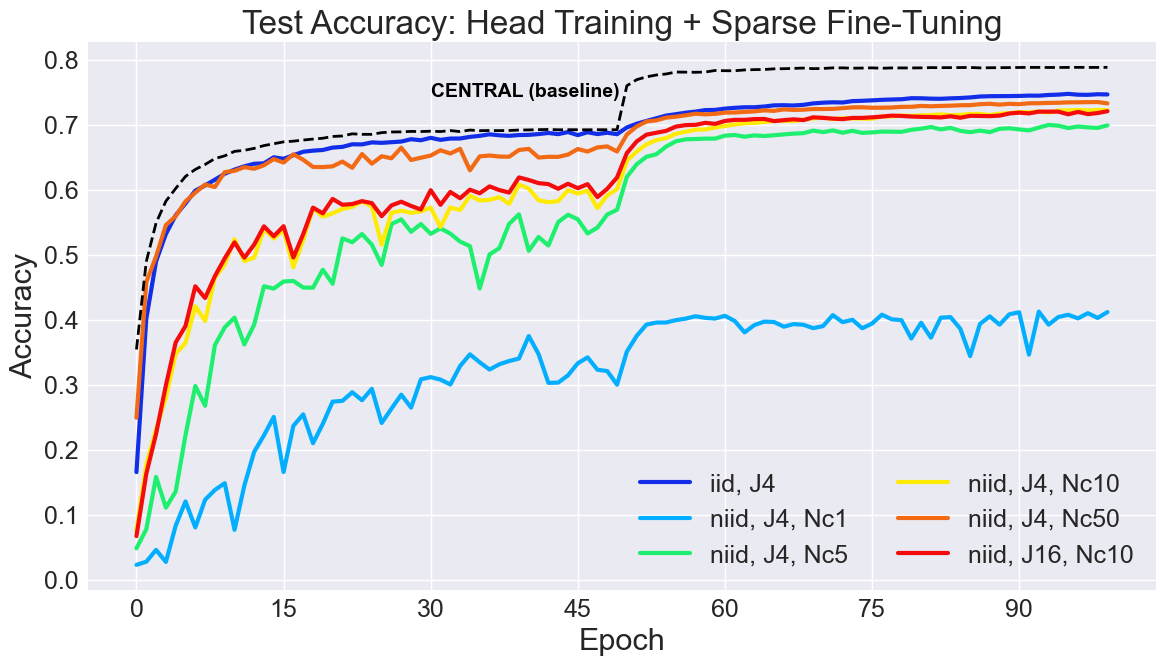

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# List of files to plot
json_files = [
    ("results_FL_HEAD_iid_J4_NcNone.json", "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4.json"),
    #("results_FL_HEAD_iid_J8_NcNone.json", "results_FL_FINE_TUNED_iid_J8_NcNone_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc1.json", "results_FL_FINE_TUNED_niid_J4_Nc1_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc5.json", "results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc10.json", "results_FL_FINE_TUNED_niid_J4_Nc10_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc50.json", "results_FL_FINE_TUNED_niid_J4_Nc50_Cal2_S0.5_1e4.json"),
    #("results_FL_HEAD_niid_J8_Nc10.json", "results_FL_FINE_TUNED_niid_J8_Nc10_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J16_Nc10.json", "results_FL_FINE_TUNED_niid_J16_Nc10_Cal2_S0.5_1e4.json")
]

# Labels
labels = [
    "iid, J4",
   # "iid, J8",
    "niid, J4, Nc1",
    "niid, J4, Nc5",
    "niid, J4, Nc10",
    "niid, J4, Nc50",
    #"niid, J8, Nc10",
    "niid, J16, Nc10"
]

colors = [
    "#0f2ce8",
    "#00aeff",
    "#1BF06C",
    "#ffea00",
    "#f36811",
    "#f50909",
#    "#b420f3",
#    "#6A696A"
]


plt.figure(figsize=(12,7))

for idx, (head_file, ft_file) in enumerate(json_files):
    # Load head training accuracies
    with open(head_file, "r") as f:
        head_data = json.load(f)
    #head_accs = head_data.get("test_accuracies", [])[-50:]
    head_accs_1 = head_data.get("test_accuracies", [])[0:80:2]
    head_accs_2 = head_data.get("test_accuracies", [])[90:101]
    head_accs = head_accs_1 + head_accs_2

    # Load fine-tuning accuracies
    with open(ft_file, "r") as f:
        ft_data = json.load(f)
    ft_accs = ft_data.get("test_accuracies", [])

    # Concatenate head (30 epoche) + fine-tuning
    combined_accs = head_accs + ft_accs

    plt.plot(combined_accs, label=labels[idx], marker='x', color=colors[idx], alpha=0.99)   #, marker=markers[idx]

# --- PLOT BASELINE (CENTRAL) ---
with open("BASELINE_CENTRAL_results_head_backbone.json", "r") as f:
    baseline = json.load(f)

baseline_head = np.array(baseline["head_only"]["test_accuracies"])
baseline_backbone = np.array(baseline["backbone_sparse"]["test_accuracies"])
offset = 0.005  # Small offset to have a better plot
baseline_head_shifted = baseline_head + offset
baseline_accs = baseline["head_only"]["test_accuracies"] + baseline["backbone_sparse"]["test_accuracies"]

baseline_accs = list(baseline_head_shifted) + list(baseline_backbone)
plt.plot(baseline_accs, "k--", linewidth=2)


# Baseline
plt.text(len(baseline_head_shifted)-20,
         baseline_head_shifted[-1] + 0.05,
         "CENTRAL (baseline)",
         color="black",
         fontsize=14,
         fontweight='bold')

# --- SETTINGS ---
plt.title("Test Accuracy: Head Training + Sparse Fine-Tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(
    fontsize=18,
    ncol=2,
    frameon=False
)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

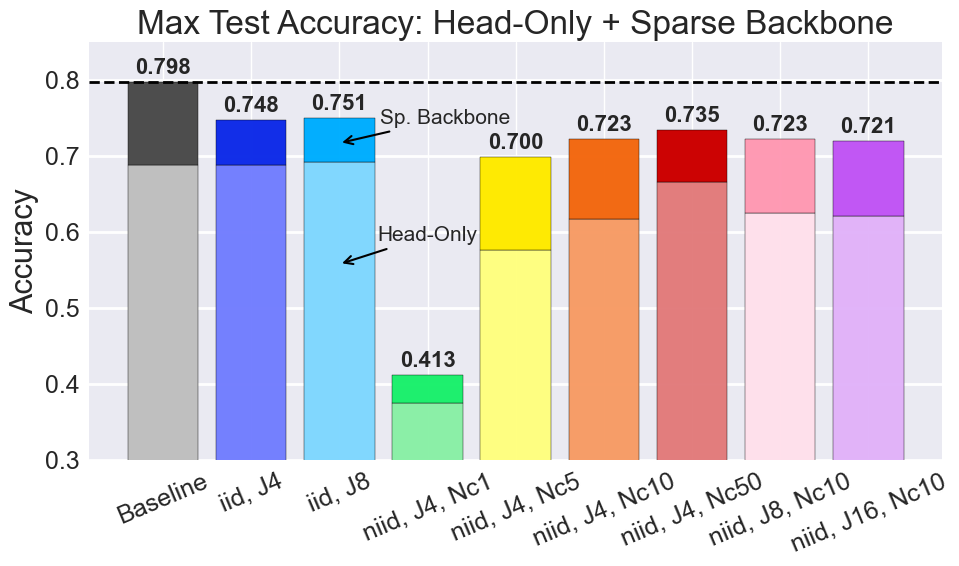

In [ ]:

json_files = [
    ("results_head_central.json", "results_backbone_central.json"),
    ("results_FL_HEAD_iid_J4_NcNone.json", "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_iid_J8_NcNone.json", "results_FL_FINE_TUNED_iid_J8_NcNone_Cal2_S0.5_1e4.json"),
    #("results_FL_HEAD_iid_J16_NcNone.json", "results_FL_FINE_TUNED_iid_J16_NcNone_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc1.json", "results_FL_FINE_TUNED_niid_J4_Nc1_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc5.json", "results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc10.json", "results_FL_FINE_TUNED_niid_J4_Nc10_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc50.json", "results_FL_FINE_TUNED_niid_J4_Nc50_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J8_Nc10.json", "results_FL_FINE_TUNED_niid_J8_Nc10_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J16_Nc10.json", "results_FL_FINE_TUNED_niid_J16_Nc10_Cal2_S0.5_1e4.json")
]

# Labels
labels = [
    "Baseline",
    "iid, J4",
    "iid, J8",
    #"iid, J16",
    "niid, J4, Nc1",
    "niid, J4, Nc5",
    "niid, J4, Nc10",
    "niid, J4, Nc50",
    "niid, J8, Nc10",
    "niid, J16, Nc10"
]


head_heights = []
backbone_heights = []

for head_file, ft_file in json_files:
    # head accuracies: max
    with open(head_file, "r") as f:
        head_data = json.load(f)
    head_acc = max(head_data.get("test_accuracies", []))
    head_heights.append(head_acc)

    # backbone accuracies: max
    with open(ft_file, "r") as f:
        ft_data = json.load(f)
    backbone_acc = max(ft_data.get("test_accuracies", []))
    backbone_heights.append(backbone_acc - head_acc)  # delta above head

x = np.arange(len(labels))

plt.figure(figsize=(10,6))


colors = [
    "#4B4B4B",
    #"#6530F1",
    "#0f2ce8",
    "#00aeff",
    "#1BF06C",
    "#ffea00",
    "#f36811",
    "#cc0000",
    "#ff99b3",
    "#c155f5"
]
colors_light = [
    "#BFBFBF",
    #"#AC99F9",
    "#737fff",
    "#80d7ff",
    "#8af0a6",
    "#ffff80",
    "#f79c66",
    "#e27c7c",
    "#ffe0eb",
    "#e1b3f9"
]

# plot head
plt.bar(x, head_heights, color=colors_light, alpha=0.99, edgecolor='black', label="Head")

# plot backbone above head
plt.bar(x, backbone_heights, bottom=head_heights, color=colors, alpha=0.99, edgecolor='black', label="Backbone")

# plot baseline
plt.axhline(y=backbone_heights[0]+head_heights[0], color="black", linestyle="--", linewidth=2)


# Arrow
plt.annotate(
    "Sp. Backbone",
    xy=(2, head_heights[2]+0.025),
    xytext=(+3.2, head_heights[2]+0.05),
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
    fontsize=15,
    ha='center'
)
plt.annotate(
    "Head-Only",
    xy=(2, backbone_heights[2]+0.5),
    xytext=(+3.0, backbone_heights[2]+0.53),
    arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
    fontsize=15,
    ha='center'
)

# Numbers above bars
for i in range(len(x)):
    total_height = head_heights[i] + backbone_heights[i]
    plt.text(
        x[i],
        total_height + 0.005,
        f"{total_height:.3f}",
        ha='center',
        va='bottom',
        fontsize=16,
        fontweight='bold'
    )


plt.xticks(x, labels, rotation=23)
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Max Test Accuracy: Head-Only + Sparse Backbone")
#plt.legend()
plt.ylim(0.3, 0.85)
plt.grid(axis='y', linewidth=2, alpha=0.99)
plt.tight_layout()
plt.show()


In [ ]:

json_files = [
    ("results_head_central.json", "results_backbone_central.json"),
    ("results_FL_HEAD_iid_J4_NcNone.json", "results_FL_FINE_TUNED_iid_J4_NcNone_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_iid_J8_NcNone.json", "results_FL_FINE_TUNED_iid_J8_NcNone_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_iid_J16_NcNone.json", "results_FL_FINE_TUNED_iid_J16_NcNone_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc1.json", "results_FL_FINE_TUNED_niid_J4_Nc1_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc5.json", "results_FL_FINE_TUNED_niid_J4_Nc5_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc10.json", "results_FL_FINE_TUNED_niid_J4_Nc10_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J4_Nc50.json", "results_FL_FINE_TUNED_niid_J4_Nc50_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J8_Nc10.json", "results_FL_FINE_TUNED_niid_J8_Nc10_Cal2_S0.5_1e4.json"),
    ("results_FL_HEAD_niid_J16_Nc10.json", "results_FL_FINE_TUNED_niid_J16_Nc10_Cal2_S0.5_1e4.json")
]

summary = []

for _, ft_file in json_files:  # ignore head file
    with open(ft_file, "r") as f:
        ft_data = json.load(f)

    test_accuracies = ft_data.get("test_accuracies", [])
    test_losses = ft_data.get("test_losses", [])

    if len(test_accuracies) == 0:
        continue  # skip empty files

    # Epoch of best accuracy (starting from 1)
    best_epoch = test_accuracies.index(max(test_accuracies)) + 1
    best_accuracy = test_accuracies[best_epoch - 1]

    # Loss corresponding to best accuracy
    corresponding_loss = test_losses[best_epoch - 1] if len(test_losses) >= best_epoch else None

    # Training time
    training_time = ft_data.get("training_time_sec", ft_data.get("time_sec", 0))

    entry = {
        "flag": ft_data.get("flag", ""),
        "J": ft_data.get("J", ""),
        "Nc": ft_data.get("Nc", ""),
        "epochs": ft_data.get("epochs", ""),
        "best_epoch": best_epoch,
        "best_test_accuracy": best_accuracy,
        "loss_at_best_accuracy": corresponding_loss,
        "training_time_sec": training_time
    }

    summary.append(entry)

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values(by=["flag", "J", "Nc"]).reset_index(drop=True)
df_summary



,flag,J,Nc,epochs,best_epoch,best_test_accuracy,loss_at_best_accuracy,training_time_sec
0,,,,,33,0.7976,0.944468,6393.355691
1,iid,4,None,100,46,0.7476,0.900601,4167.240000
2,iid,8,None,50,50,0.7506,0.945422,3767.470000
3,iid,16,None,50,39,0.7512,1.019528,6560.050000
4,niid,4,1,50,43,0.4125,6.801700,1867.930000
5,niid,4,5,50,44,0.6998,1.306760,2420.160000
6,niid,4,10,50,47,0.7229,0.974709,2448.940000
7,niid,4,50,50,49,0.7350,1.150596,2484.800000
8,niid,8,10,50,42,0.7233,1.021630,3850.160000
9,niid,16,10,50,50,0.7209,1.070875,6932.600000


### Training Head + Backbone vs Free Training

In [ ]:
set_seeds(123)
checkpoint_path = None


#######################################
# === PARAMETERS TO SET ===
FLAG = "niid"    # 'niid'
Nc = 10       # {1,5,10,50}
J = 4           # {4,8,16}
SPARSITY = 0.5
C_ROUNDS = 2     # calibration rounds
######################################


###### SCNARIOS #########################
# S1: Full training (150)
# S2: Head (50) + Backbone (100)
# S3: Head (50) + All (100)
# S4: Head (50) + Backbone (50) + All (50)
##########################################




# === GENERAL PARAMETERS ===
N_EP_HEAD = 50
N_EP_BACKBONE = 100

K = 100
C = 0.1
LR = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
T_MAX = J
VERBOSE = True
KEEP = 'least'


# === CREATE CLIENTS ===
clients = create_client_objects(
    data=tot_train_data, K=K, Nc=Nc, flag=FLAG,
    batch_size=BATCH_SIZE, verbose=VERBOSE
)

In [ ]:
""" TRAINING HEAD ONLY """

set_seeds(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD DINO BACKBONE ===
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16.eval()  # evaluation mode
dino_vits16 = dino_vits16.to(device)

# === CREATE GLOBAL MODEL (trainable head, frozen backbone) ===
global_model = DINOWithHead(dino_vits16, num_classes=100).to(device)
for param in global_model.backbone.parameters():
    param.requires_grad = False
for param in global_model.head.parameters():
    param.requires_grad = True
global_model.head.train()    # Trainig mode for the head

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()


# === TRAINING HEAD ====
start_time = time.time()
best_head_model, test_losses_head, test_accuracies_head, avg_train_losses_head, avg_train_accuracies_head = train_test_model_FL(
        global_model=global_model,
        criterion=criterion,
        LR=LR,
        MOMENTUM=MOMENTUM,
        WEIGHT_DECAY=WEIGHT_DECAY,
        T_MAX=T_MAX,
        clients=clients,
        val_test_loader=test_loader,
        num_epochs = N_EP_HEAD,
        C=C,
        J=J,
        checkpoint_path=None,
        checkpoints=True,
        verbose=VERBOSE,
        use_sparse=False    # Using standard SGD
    )
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_head = {
        "flag": FLAG,
        "J": J,
        "Nc": Nc,
        "epochs": N_EP_HEAD,
        #"avg_train_losses": avg_train_losses_head,
        #"avg_train_accuracies": avg_train_accuracies_head,
        "test_losses": test_losses_head,
        "test_accuracies": test_accuracies_head,
        "training_time_sec": training_time
    }

# === General Json ===
results_all = {
    "head_only": results_FL_head
}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Copy of the model with the trianed head for Scnearios 2,3,4
best_head_model_cpu = copy.deepcopy(best_head_model).cpu()

In [ ]:
set_seeds(123)

###############################
# === SCENARIO 1 (All free) ===
###############################
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16.eval()  # evaluation mode
dino_vits16 = dino_vits16.to(device)

# === CREATE GLOBAL MODEL (trainable head, frozen backbone) ===
global_model_scen1 = DINOWithHead(dino_vits16, num_classes=100).to(device)    # Start from scratch
global_model_scen1.train()  # All in train modality
for param in global_model_scen1.parameters():
    param.requires_grad = True



#################################################
# === SCENARIO 2 (Head + Backbone (no Head)) ===
#################################################
global_model_scen2 = copy.deepcopy(best_head_model_cpu).to(device)   # Pre-trained head
for param in global_model_scen2.backbone.parameters():
    param.requires_grad = True
for param in global_model_scen2.head.parameters():
    param.requires_grad = False
global_model_scen2.head.eval()   # Head only evaluation
global_model_scen2.backbone.train()   # Backbone trianing




##################################
# === SCENARIO 3 (Head + All) ===
###################################
global_model_scen3 = copy.deepcopy(best_head_model_cpu).to(device)   # Pre-trained head
global_model_scen3.train()   # All training
for param in global_model_scen3.parameters():
    param.requires_grad = True



######################################################
# === SCENARIO 4 (Head + Backbone (no Head) + All) ===
######################################################
global_model_scen4 = copy.deepcopy(best_head_model_cpu).to(device)   # Pre-trained head
for param in global_model_scen4.backbone.parameters():
    param.requires_grad = True
for param in global_model_scen4.head.parameters():
    param.requires_grad = False
global_model_scen4.head.eval()   # Head only evaluation
global_model_scen4.backbone.train()   # Backbone trianing

# Later for Scenario 4 the Head will be freed

In [ ]:
###############################
# === SCENARIO 1 (All free) ===
###############################

set_seeds(123)

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

# === TRAINING and TESTING ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, global_model_scen1, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=global_model_scen1,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs= N_EP_BACKBONE + N_EP_HEAD,    # Sum of the 2 epochs
    C=C,
    J=J,
    checkpoint_path=None,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_sparse_1 = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP_BACKBONE + N_EP_HEAD,
    "c_rounds": C_ROUNDS,
    "c_time": c_time,
    "sparsity": SPARSITY,
    #"avg_train_losses": avg_train_losses,
    #"avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time
}

# === General Json ===
results_all["scenario1_free"] = results_FL_sparse_1

In [ ]:
#################################################
# === SCENARIO 2 (Head + Backbone (no Head)) ===
################################################

set_seeds(123)

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

# === TRAINING and TESTING ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, global_model_scen2, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=global_model_scen2,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs= N_EP_BACKBONE,    # Only 50 epochs
    C=C,
    J=J,
    checkpoint_path=None,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_sparse_2 = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP_BACKBONE,
    "c_rounds": C_ROUNDS,
    "c_time": c_time,
    "sparsity": SPARSITY,
    #"avg_train_losses": avg_train_losses,
    #"avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time
}

# === General Json ===
results_all["scenario2_backbone"] = results_FL_sparse_2

In [ ]:
##################################
# === SCENARIO 3 (Head + All) ===
###################################

set_seeds(123)

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

# === TRAINING and TESTING ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, global_model_scen3, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=global_model_scen3,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs= N_EP_BACKBONE,    # Only 50 epochs
    C=C,
    J=J,
    checkpoint_path=None,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)
end_time = time.time()
training_time = round(end_time - start_time, 2)

# === SAVING RESULTS ===
results_FL_sparse_3 = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP_BACKBONE,
    "c_rounds": C_ROUNDS,
    "c_time": c_time,
    "sparsity": SPARSITY,
    #"avg_train_losses": avg_train_losses,
    #"avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time
}

# === General Json ===
results_all["scenario3_all"] = results_FL_sparse_3

In [ ]:
######################################################
# === SCENARIO 4 (Head + Backbone (no Head) + All) ===
######################################################

set_seeds(123)

# === LOSS FUNCTION ===
criterion = nn.CrossEntropyLoss()

# === TRAINING and TESTING ===
start_time = time.time()

# === CALIBRATION MASK ===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, global_model_scen4, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time_1 = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
current_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=global_model_scen4,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs= N_EP_BACKBONE - N_EP_HEAD,    # Only 30 epochs
    C=C,
    J=J,
    checkpoint_path=None,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)

###################################################################
# Unfreezing the head
for param in current_global_model.head.parameters():   # Current model!
    param.requires_grad = True
current_global_model.train()   # All in trian modality



# === RE - CALIBRATION MASK (head too)===
start_c_time = time.time()
print(f'Masking, selection method: {KEEP}')
calibrate_all_clients(clients, current_global_model, device, R=C_ROUNDS, final_sparsity=SPARSITY, lr=LR, keep = KEEP)    #imported_model_calib
end_c_time = time.time()
c_time_2 = round(end_c_time - start_c_time, 2)

# === TRAIN FL ===
best_global_model, test_losses, test_accuracies, avg_train_losses, avg_train_accuracies = train_test_model_FL(
    global_model=current_global_model,
    criterion=criterion,
    LR=LR,
    MOMENTUM=MOMENTUM,
    WEIGHT_DECAY=WEIGHT_DECAY,
    T_MAX=T_MAX,
    clients=clients,
    val_test_loader=test_loader,
    num_epochs= N_EP_HEAD,    # The remaining 20 calibrations
    C=C,
    J=J,
    checkpoint_path=None,
    checkpoints=True,
    verbose=VERBOSE,
    use_sparse=True     # Using sparse SGD
)

end_time = time.time()
training_time = round(end_time - start_time, 2)



# === SAVING RESULTS ===
results_FL_sparse_4 = {
    "flag": FLAG,
    "J": J,
    "Nc": Nc,
    "epochs": N_EP_BACKBONE,   # Tot 50 epochs
    "c_rounds": C_ROUNDS,
    "c_time": c_time_1 + c_time_2,
    "sparsity": SPARSITY,
    #"avg_train_losses": avg_train_losses,
    #"avg_train_accuracies": avg_train_accuracies,
    "test_losses": test_losses,
    "test_accuracies": test_accuracies,
    "training_time_sec": training_time
}

# === General Json ===
results_all["scenario4_backbone_all"] = results_FL_sparse_4

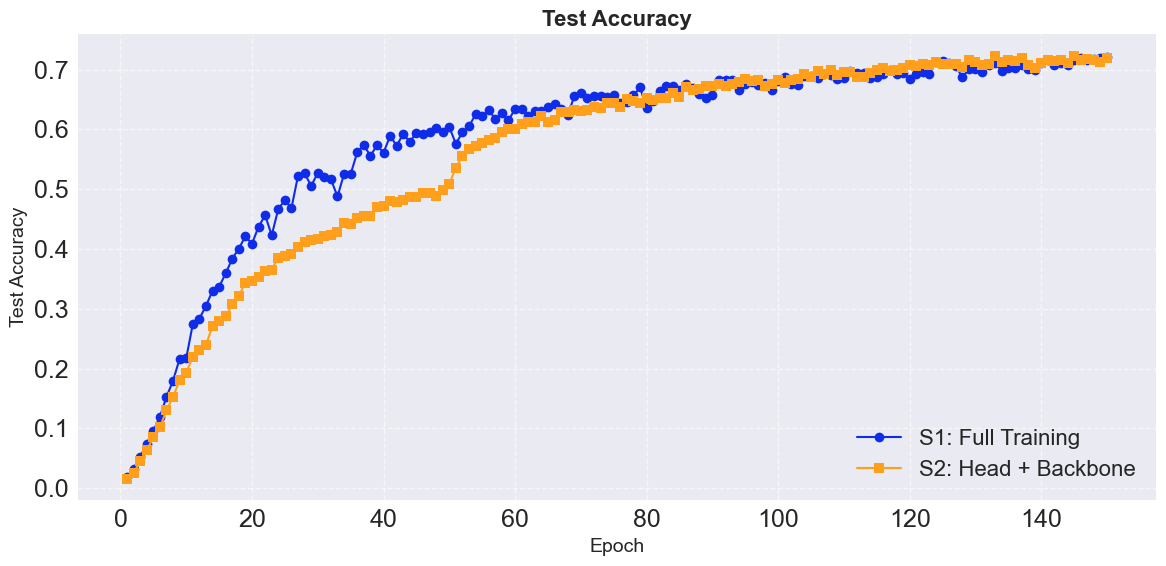

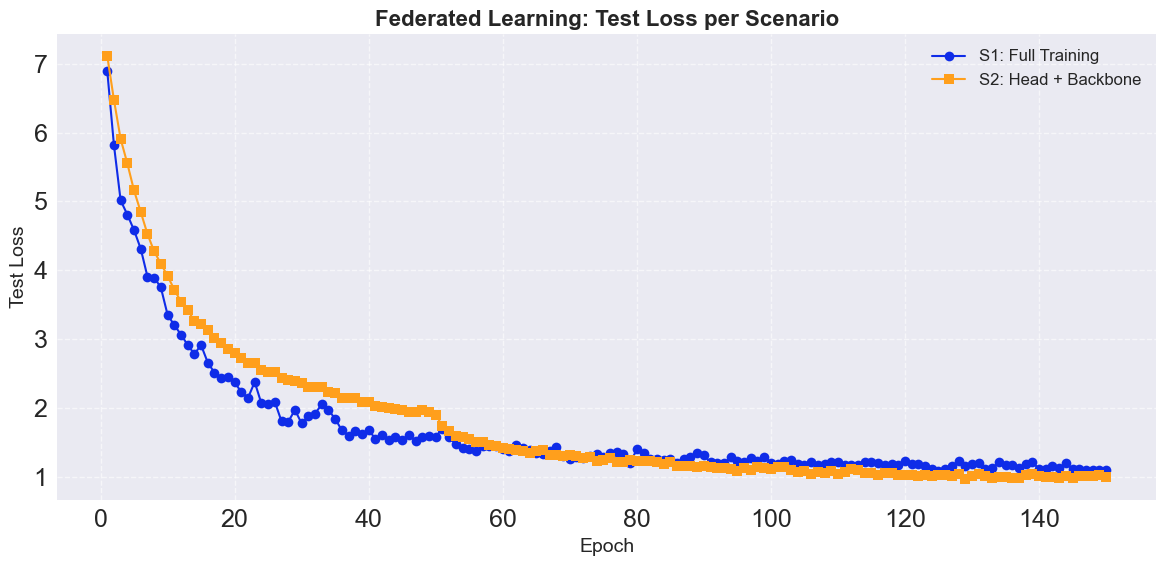

In [ ]:
# === Load the federated learning results ===
with open("results_FL_head_big.json", "r") as f:
    results_head = json.load(f)

with open("results_FL_sparse_1_big.json", "r") as f:
    results_s1 = json.load(f)

with open("results_FL_sparse_2_big.json", "r") as f:
    results_s2 = json.load(f)

#with open("results_FL_sparse_3_big.json", "r") as f:
#    results_s3 = json.load(f)

#with open("results_FL_sparse_4_big.json", "r") as f:
#    results_s4 = json.load(f)

# === Combine accuracies for scenarios with separate head training ===
acc_s2_combined = results_head["test_accuracies"] + results_s2["test_accuracies"]
#acc_s3_combined = results_head["test_accuracies"] + results_s3["test_accuracies"]
#acc_s4_combined = results_head["test_accuracies"] + results_s4["test_accuracies"]

# Similarly for loss
loss_s2_combined = results_head["test_losses"] + results_s2["test_losses"]
#loss_s3_combined = results_head["test_losses"] + results_s3["test_losses"]
#loss_s4_combined = results_head["test_losses"] + results_s4["test_losses"]

# Scenario 1 is full training (no separate head)
acc_s1 = results_s1["test_accuracies"]
loss_s1 = results_s1["test_losses"]

# === Cut last epochs if needed ===
cut_last = 0  # or set a number if you want to remove last epochs
acc_s1 = acc_s1[:-cut_last] if cut_last else acc_s1
acc_s2_combined = acc_s2_combined[:-cut_last] if cut_last else acc_s2_combined
#acc_s3_combined = acc_s3_combined[:-cut_last] if cut_last else acc_s3_combined
#acc_s4_combined = acc_s4_combined[:-cut_last] if cut_last else acc_s4_combined

loss_s1 = loss_s1[:-cut_last] if cut_last else loss_s1
loss_s2_combined = loss_s2_combined[:-cut_last] if cut_last else loss_s2_combined
#loss_s3_combined = loss_s3_combined[:-cut_last] if cut_last else loss_s3_combined
#loss_s4_combined = loss_s4_combined[:-cut_last] if cut_last else loss_s4_combined

# === Define stylish colors ===
colors = {
    "S1": "#0f2ce8",  # blu intenso
    "S2": "#ff9f1c",  # arancio
    "S3": "#1BF06C",  # verde acceso
    "S4": "#c155f5"   # viola/fucsia
}

markers = {
    "S1": "o",
    "S2": "s",
    "S3": "^",
    "S4": "d"
}

# === Plot Test Accuracy ===
plt.figure(figsize=(12,6))
plt.title("Test Accuracy", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Test Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.plot(range(1,len(acc_s1)+1), acc_s1, label='S1: Full Training', color=colors["S1"], marker=markers["S1"], linewidth=1.5)
plt.plot(range(1,len(acc_s2_combined)+1), acc_s2_combined, label='S2: Head + Backbone', color=colors["S2"], marker=markers["S2"], linewidth=1.5)
#plt.plot(range(1,len(acc_s3_combined)+1), acc_s3_combined, label='S3: Head + All', color=colors["S3"], marker=markers["S3"], linewidth=1.5)
#plt.plot(range(1,len(acc_s4_combined)+1), acc_s4_combined, label='S4: Head + Backbone + All', color=colors["S4"], marker=markers["S4"], linewidth=1.5)

plt.legend(loc='lower right', fontsize=16)
plt.tight_layout()
plt.show()

# === Plot Test Loss ===
plt.figure(figsize=(12,6))
plt.title("Federated Learning: Test Loss per Scenario", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Test Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.plot(range(1,len(loss_s1)+1), loss_s1, label='S1: Full Training', color=colors["S1"], marker=markers["S1"], linewidth=1.5)
plt.plot(range(1,len(loss_s2_combined)+1), loss_s2_combined, label='S2: Head + Backbone', color=colors["S2"], marker=markers["S2"],linewidth=1.5)
#plt.plot(range(1,len(loss_s3_combined)+1), loss_s3_combined, label='S3: Head + All', color=colors["S3"], linewidth=1.5)
#plt.plot(range(1,len(loss_s4_combined)+1), loss_s4_combined, label='S4: Head + Backbone + All', color=colors["S4"], linewidth=1.5)

plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


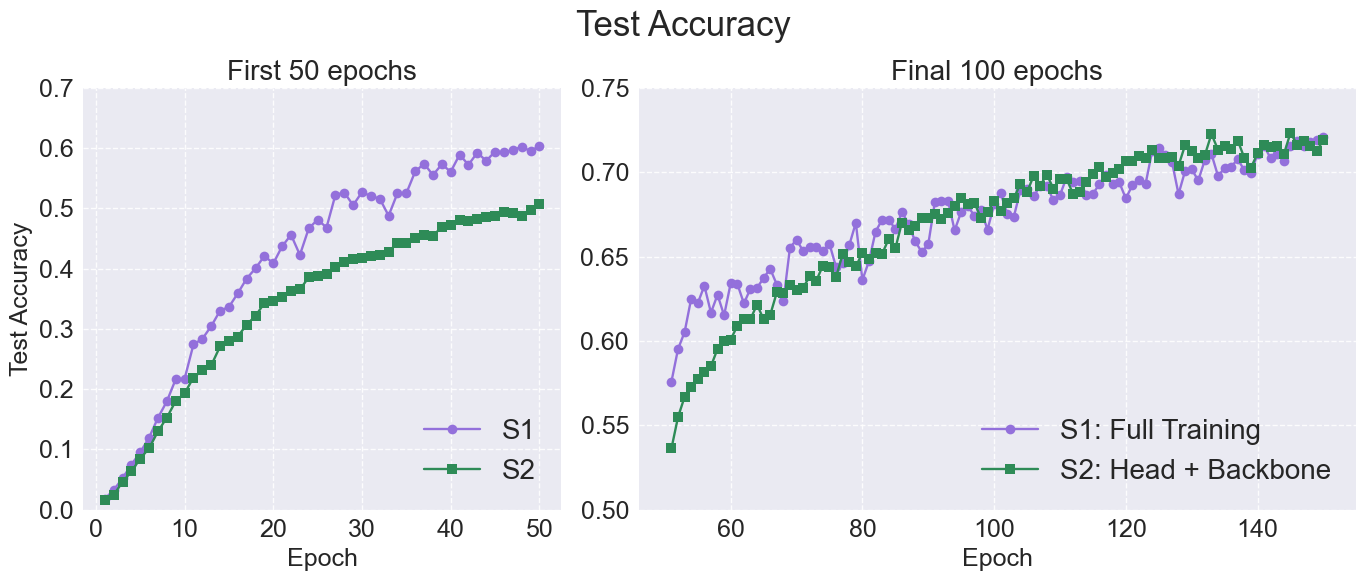

In [ ]:
# === Load results ===
with open("results_FL_head_big.json", "r") as f:
    results_head = json.load(f)

with open("results_FL_sparse_1_big.json", "r") as f:
    results_s1 = json.load(f)

with open("results_FL_sparse_2_big.json", "r") as f:
    results_s2 = json.load(f)


# === Take 50 epochs for head, 100 for fine-tuning ===
left_ep = 50
right_ep = 100

"""ACCURACY"""
acc_left_1 = results_s1["test_accuracies"][:left_ep]
acc_left_2 = results_head["test_accuracies"][:left_ep]

# Truncate fine-tuning results
acc_right_1 = results_s1["test_accuracies"][left_ep:]
acc_right_2 = results_s2["test_accuracies"]

# === Colors & markers ===
colors = {"S1": 'mediumpurple', "S2": 'seagreen'}
markers = {"S1": "o", "S2": "s"}

# === Plot Test Accuracy (Head vs Fine-tuning) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False,  gridspec_kw={'width_ratios': [1.2, 1.8]})

# --- Left: Head phase ---
axes[0].set_title("First 50 epochs", fontsize=20)
axes[0].set_xlabel("Epoch", fontsize=18)
axes[0].set_ylabel("Test Accuracy", fontsize=18)
axes[0].grid(True, linestyle="--", alpha=0.9)

axes[0].plot(range(1, left_ep+1), acc_left_1,
             label="S1", color=colors["S1"], marker=markers["S1"], linewidth=1.7)
axes[0].plot(range(1, left_ep+1), acc_left_2,
             label="S2", color=colors["S2"], marker=markers["S2"], linewidth=1.7)
axes[0].set_ylim(0, 0.7)
axes[0].legend(fontsize=20, loc="lower right")

# --- Right: Fine-tuning phase ---
axes[1].set_title("Final 100 epochs", fontsize=20)
axes[1].set_xlabel("Epoch", fontsize=18)
axes[1].grid(True, linestyle="--", alpha=0.9)

axes[1].plot(range(left_ep+1, left_ep+right_ep+1), acc_right_1,
             label="S1: Full Training", color=colors["S1"], marker=markers["S1"], linewidth=1.7)
axes[1].plot(range(left_ep+1, left_ep+right_ep+1), acc_right_2,
             label="S2: Head + Backbone", color=colors["S2"], marker=markers["S2"], linewidth=1.7)
axes[1].set_ylim(0.5, 0.75)
axes[1].legend(fontsize=20, loc="lower right")


fig.suptitle("Test Accuracy", fontsize=25)

plt.tight_layout()
plt.subplots_adjust(wspace=0.13, top=0.85)
plt.show()



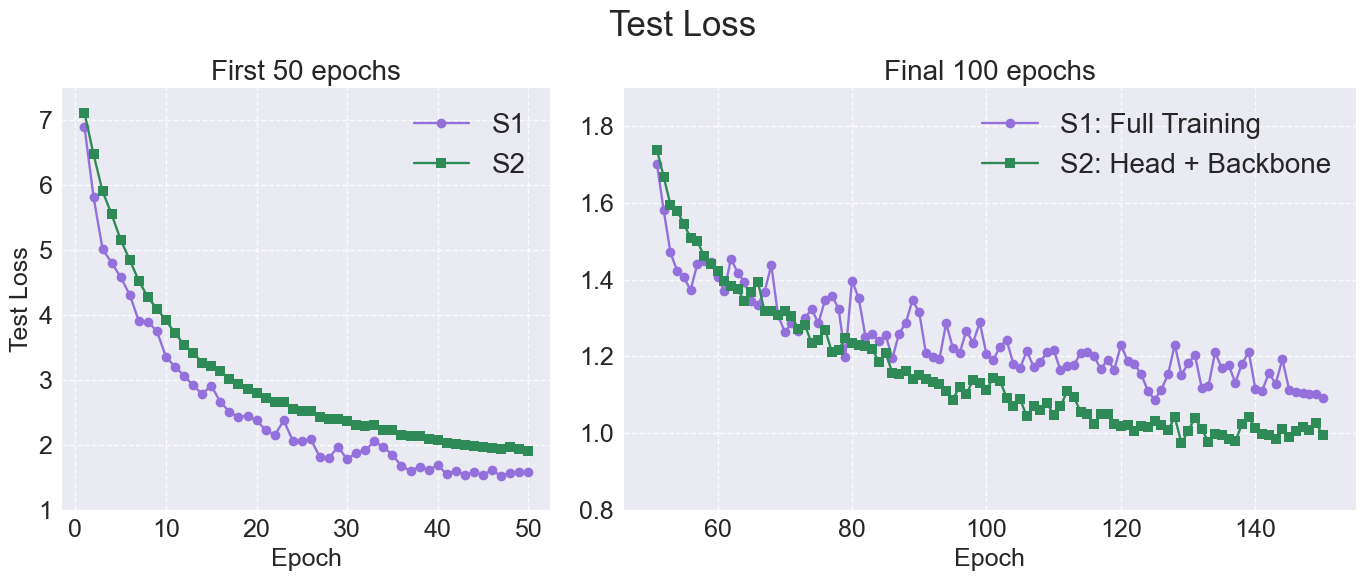

In [ ]:
""" LOSS """
loss_left_1 = results_s1["test_losses"][:left_ep]
loss_left_2 = results_head["test_losses"][:left_ep]

loss_right_1 = results_s1["test_losses"][left_ep:]
loss_right_2 = results_s2["test_losses"]

# === Plot Test Loss (Head vs Fine-tuning) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False, gridspec_kw={'width_ratios': [1.2, 1.8]})

# --- Left: Head phase ---
axes[0].set_title("First 50 epochs", fontsize=20)
axes[0].set_xlabel("Epoch", fontsize=18)
axes[0].set_ylabel("Test Loss", fontsize=18)
axes[0].grid(True, linestyle="--", alpha=0.9)

axes[0].plot(range(1, left_ep+1), loss_left_1,
             label="S1", color=colors["S1"], marker=markers["S1"], linewidth=1.7)
axes[0].plot(range(1, left_ep+1), loss_left_2,
             label="S2", color=colors["S2"], marker=markers["S2"], linewidth=1.7)
axes[0].set_ylim(1, 7.5)  # adatta in base ai valori della loss
axes[0].legend(fontsize=20, loc="upper right")

# --- Right: Fine-tuning phase ---
axes[1].set_title("Final 100 epochs", fontsize=20)
axes[1].set_xlabel("Epoch", fontsize=18)
axes[1].grid(True, linestyle="--", alpha=0.9)

axes[1].plot(range(left_ep+1, left_ep+right_ep+1), loss_right_1,
             label="S1: Full Training", color=colors["S1"], marker=markers["S1"], linewidth=1.7)
axes[1].plot(range(left_ep+1, left_ep+right_ep+1), loss_right_2,
             label="S2: Head + Backbone", color=colors["S2"], marker=markers["S2"], linewidth=1.7)
axes[1].set_ylim(0.8, 1.9)
axes[1].legend(fontsize=20, loc="upper right")

fig.suptitle("Test Loss", fontsize=25)
plt.tight_layout()
plt.subplots_adjust(wspace=0.12, top=0.85)
plt.show()


In [ ]:
import pandas as pd

# --- Build summary dictionary ---
summary_dict = {
    "Scenario": ["S1: Full training", "S2: Head", "S2: Backbone"],
    "Best Accuracy": [
        best_acc_s1,
        max(acc_s2_head),
        max(acc_s2_back)
    ],
    "Epoch of Best Accuracy": [
        best_epoch_s1,
        acc_s2_head.index(max(acc_s2_head)) + 1,
        acc_s2_back.index(max(acc_s2_back)) + 1 + left_ep  # offset because backbone starts after head
    ],
    "Loss at Best Accuracy": [
        corresponding_loss_s1,
        loss_s2_head[acc_s2_head.index(max(acc_s2_head))],
        loss_s2_back[acc_s2_back.index(max(acc_s2_back))]
    ],
    "Total Time (s)": [
        total_time_s1,
        results_head["training_time_sec"],
        results_s2["training_time_sec"]
    ]
}

# --- Create DataFrame ---
df_summary = pd.DataFrame(summary_dict)

# --- Display ---
pd.set_option("display.float_format", "{:.4f}".format)
df_summary


,Scenario,Best Accuracy,Epoch of Best Accuracy,Loss at Best Accuracy,Total Time (s)
0,S1: Full training,0.7211,150,1.0916,6154.9000
1,S2: Head,0.5082,50,1.8991,953.8700
2,S2: Backbone,0.7234,145,0.9889,4251.1900
